# Baseline AQI Reconstruction (Upper-Bound Model)

This notebook establishes an **upper-bound baseline** for AQI prediction by
reconstructing AQI using pollutant indicators that are directly involved in its
computation (e.g., PM2.5, PM10, gaseous pollutants).

**Important note:**  
This model intentionally allows target leakage and is **not intended for
forecasting or real-world deployment**. Its sole purpose is to quantify the
maximum achievable performance and serve as a reference point for more realistic
models developed later.


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("/kaggle/input/delhi-aqi-2/delhi_ncr_aqi_dataset.csv")
df.head()


In [ ]:
df.info()

The baseline model includes pollutant indicators that directly contribute to AQI
calculation, along with a small set of meteorological and temporal variables.
This feature set is sufficient to reconstruct AQI and establish an upper-bound
benchmark, without introducing unnecessary complexity.


In [15]:
features = [
    "pm25", "pm10", "no2", "so2", "co", "o3",
    "temperature", "humidity", "wind_speed",
    "season", "day_of_week"
]

X = df[features]
y = df["aqi"]


In [16]:
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

encoded = ohe.fit_transform(X[["season", "day_of_week"]])
encoded_df = pd.DataFrame(
    encoded,
    columns=ohe.get_feature_names_out(["season", "day_of_week"])
)

X = pd.concat(
    [X.drop(columns=["season", "day_of_week"]), encoded_df],
    axis=1
)


## Train–Test Split

A random train–test split is used in this notebook. Since the objective is AQI
reconstruction rather than time-series forecasting, temporal ordering is not
enforced at this stage.


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


The AQI distribution is highly right-skewed with a visible cap at 500, indicating that extreme pollution events are frequent but censored by the AQI scale. This motivates careful interpretation of regression-based models.


In [18]:
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

AQI exhibits strong seasonal variation, with winter and post-monsoon periods showing consistently higher pollution levels. This highlights the importance of temporal and seasonal context in forecasting AQI.


In [19]:
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

rmse, r2


(np.float64(44.32479251063911), 0.9331754793665604)

## Results Interpretation

The high R² and low RMSE obtained in this model are expected outcomes, as AQI is
mathematically derived from the included pollutant indicators. These results
should not be interpreted as evidence of forecasting capability, but rather as
confirmation of the dataset’s internal consistency.


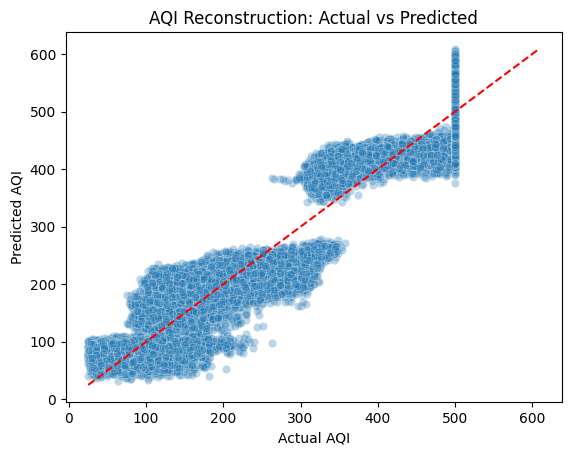

In [20]:
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)

# Perfect prediction line
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--")

plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title("AQI Reconstruction: Actual vs Predicted")
plt.show()


The strong alignment along the diagonal confirms near-perfect AQI reconstruction.
Deviations at higher AQI values reflect saturation of the AQI scale at 500 rather
than model error. This behavior is expected in a leakage-aware baseline.
